In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
labels = pd.read_csv("./data/samples.csv", dtype={"notes":"str"})

In [3]:
labels

,idx,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,samples,SR,session_id,notes
0,0,0.883266,-0.043772,-0.116724,-1.767878,-0.042979,1.811221,0.039998,0.0,80896,16000,0,
1,1,0.728893,-0.042582,-0.118711,-1.768172,-0.042987,1.811217,0.039660,0.0,80896,16000,0,
2,2,0.553810,-0.041615,-0.103017,-1.768377,-0.043015,1.811211,0.039652,0.0,80896,16000,0,
3,3,0.410330,-0.038282,-0.095798,-1.768288,-0.043018,1.811259,0.038886,0.0,80896,16000,0,
4,4,0.168166,-0.039483,-0.098186,-1.767707,-0.043345,1.811258,0.040031,0.0,80896,16000,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,-0.282973,0.029687,-0.062975,-1.621025,-0.040649,1.695863,0.322559,0.0,80896,16000,9,
96,96,-0.435140,0.030698,-0.065266,-1.621268,-0.040653,1.695872,0.324908,0.0,80896,16000,9,
97,97,-0.602617,0.035977,-0.063283,-1.621502,-0.040653,1.695867,0.324431,0.0,80896,16000,9,
98,98,-0.811287,0.038515,-0.050218,-1.621893,-0.040653,1.696152,0.323721,0.0,80896,16000,9,


(-75.0, 75.0)

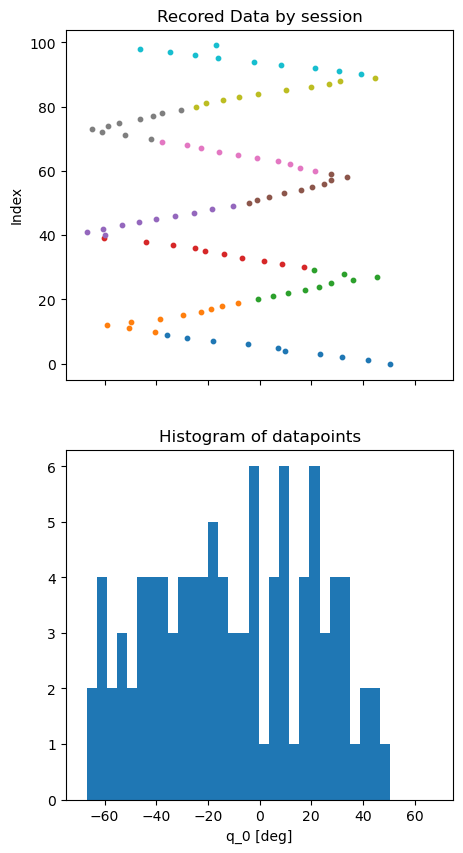

In [4]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5,10))

for sess in range(10):
    session  = labels[labels.session_id==sess]
    axs[0].scatter(np.rad2deg(session.q_0), session.idx, s=10)

axs[0].set_title("Recored Data by session")
axs[0].set_ylabel("Index")

axs[1].hist(np.rad2deg(labels.q_0), bins=30)
axs[1].set_title("Histogram of datapoints")
axs[1].set_xlabel("q_0 [deg]")
plt.xlim((-75,75))

In [5]:
labels.iloc[0].q_0

np.float64(0.8832664489746094)

In [ ]:
import scipy.io.wavfile
import os

inputpath = "./data" 
inputlength =  5
SR = 16000
outputlength = 4096//2
applyFFT = True

inputfiles = os.listdir(inputpath)

split_into = (inputlength * SR // outputlength)
output_datapoints = len(inputfiles) * split_into
req_inputlength = split_into * outputlength

print(f"Splitting each input into {split_into} datapoints, resulting in {output_datapoints} samples")

X = np.zeros((output_datapoints, outputlength))
y = np.full((output_datapoints, 2), np.nan)

for i, file in enumerate(inputfiles):
    if file.split(".")[1] != "wav":
        continue
    sr, data = scipy.io.wavfile.read(inputpath + "/" + file)
    idx = int(file.split(".")[0])
    if sr != SR:
        raise(f"Samplerate of {file} is {sr} instead of {SR}")
    
    if len(data) < req_inputlength:
        raise(f"File {file} is not long enough")
    
    start_of_block = (len(data) - req_inputlength) // 2
    data_block = data[start_of_block:start_of_block+req_inputlength, 1]
    X[i*split_into:(i+1)*split_into, :] = data_block.reshape((split_into, outputlength))
    y[i*split_into:(i+1)*split_into, :] = np.array((idx, labels.iloc[idx].q_0))

if applyFFT:
    # TODO Hamming (or other) window?
    print("applying FFT")
    X = np.abs(np.fft.rfft(X))

Splitting each input into 39 datapoints, resulting in 3978 samples
hi
applying FFT


Text(0.5, 0, 'frequency')

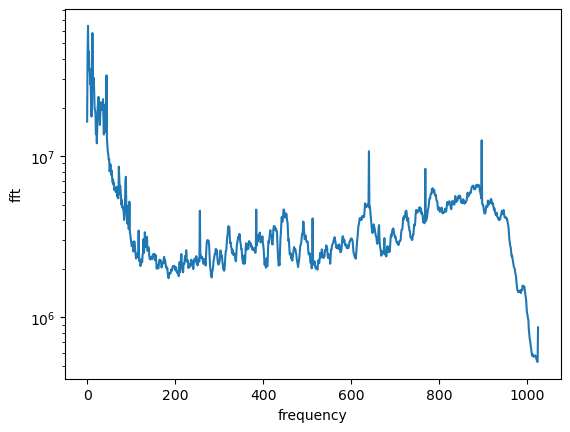

In [20]:
sample_rate = 16000
freq = np.fft.rfftfreq(4096, d=1./sample_rate)


plt.plot(np.sum(X, axis=0))

plt.yscale("log")
plt.ylabel("fft")
plt.xlabel("frequency")

In [85]:
rng = np.random.default_rng(0)
train_fraction = 0.7
train_idx = rng.choice(np.arange(len(labels)), int(len(labels)*train_fraction), replace=False)
train_samples = int(train_fraction*len(X))

X_train = np.zeros((0, X.shape[1]))
X_test = np.zeros((0, X.shape[1]))
y_train = np.zeros((0,))
y_test = np.zeros((0, ))
for idx in range(len(labels)):
    indizes = y[:,0] == idx
    if idx in train_idx:
        X_train = np.vstack((X_train, X[indizes]))
        y_train = np.hstack((y_train, y[indizes,1]))
    else:
        X_test = np.vstack((X_test, X[indizes]))
        y_test = np.hstack((y_test, y[indizes,1]))


In [82]:
for i in np.unique(y_train[:,0]):
    if np.sum(y_train[:, 0] == i) != split_into:
        print(i, np.sum(y_train[:, 0] == i))

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_scaled = StandardScaler().fit_transform(X)
X_decomp = PCA(n_components=2).fit_transform(X_scaled)

(-10.0, 15.0)

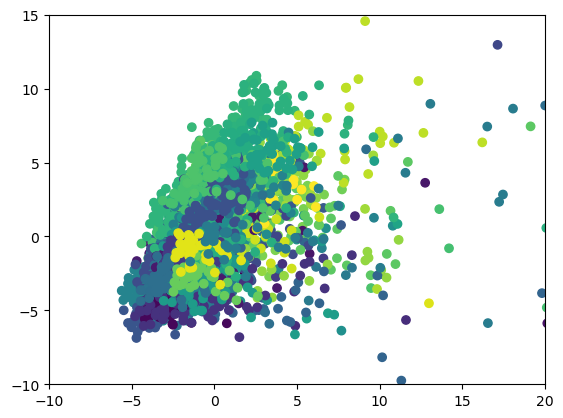

In [89]:
plt.scatter(X_decomp[:,0], X_decomp[:,1], c=y[:,1])
plt.xlim((-10,20))
plt.ylim((-10,15))

In [90]:
ynorm = np.max(np.abs(y)) + 0.01

def nonlinear_projection_head(z):
    return (1/(1+np.exp(-z))*2 - 1) * ynorm

def nonlinear_projection_head_inv(y_true):
    normed_y = (y_true / ynorm)/2 + 0.5
    return np.log(normed_y/(1-normed_y))

In [91]:
np.allclose(y, nonlinear_projection_head(nonlinear_projection_head_inv(y)))

False

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


clf = make_pipeline(StandardScaler(), LinearRegression())
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9468443055350089

In [93]:
clf.score(X_test, y_test)

0.7935817384606803

(np.float64(-72.5298418048605),
 np.float64(50.066514171942046),
 np.float64(-141.38418591291457),
 np.float64(70.25269952788496))

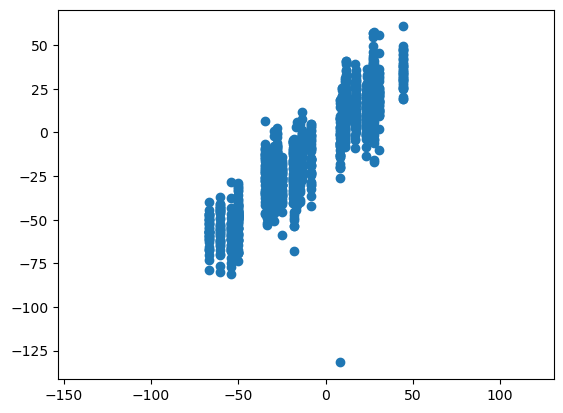

In [94]:
deg_preds = np.rad2deg(clf.predict(X_test))
plt.scatter(np.rad2deg((y_test)), deg_preds)
plt.axis("equal")

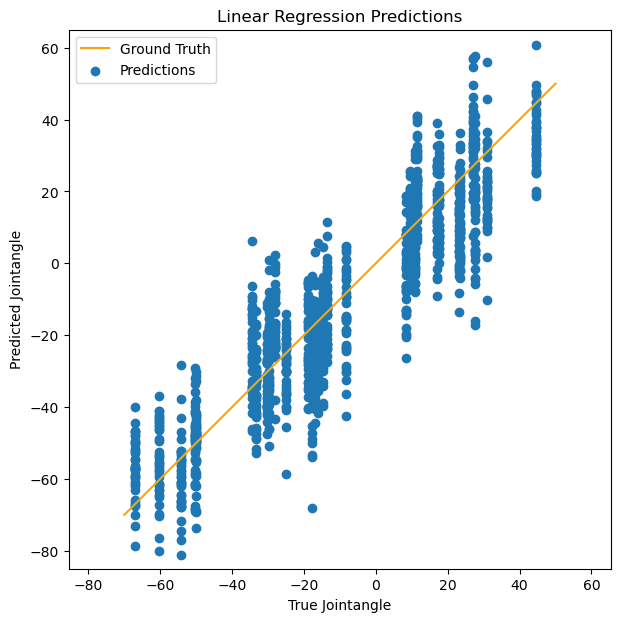

In [174]:
deg_preds = np.rad2deg(clf.predict(X_test))
plt.figure(figsize=(7,7))
plt.plot((-70,50), (-70,50), c="orange", label="Ground Truth")
plt.scatter(np.rad2deg((y_test)), deg_preds, label="Predictions")
plt.axis("equal")
plt.ylim((-85,65))
plt.xlabel("True Jointangle")
plt.ylabel("Predicted Jointangle")
plt.title("Linear Regression Predictions")
plt.legend()

In [96]:
deviation = np.sqrt(np.sum((deg_preds-np.rad2deg(y_test))**2)/len(y_test))

In [97]:
print(deviation)

13.495438131691452


In [172]:
def make_errorbar_plot(y_true, y_pred):
    y_pred = y_pred.reshape(-1, split_into)
    x = y_true[::split_into]
    avg = np.average(y_pred, axis=1)
    std = np.std(y_pred, axis=1)

    plt.figure(figsize=(7,7))
    plt.plot((-70,50), (-70,50), c="orange", label="ground truth")
    plt.errorbar(x, avg, std,fmt='o', label="predicted values")
    plt.axis("equal")
    plt.ylim((-60,40))
    plt.xlabel("True Jointangle")
    plt.ylabel("Predicted Jointangle")
    plt.title("Average of the Linear Regression Predictions")
    plt.legend()

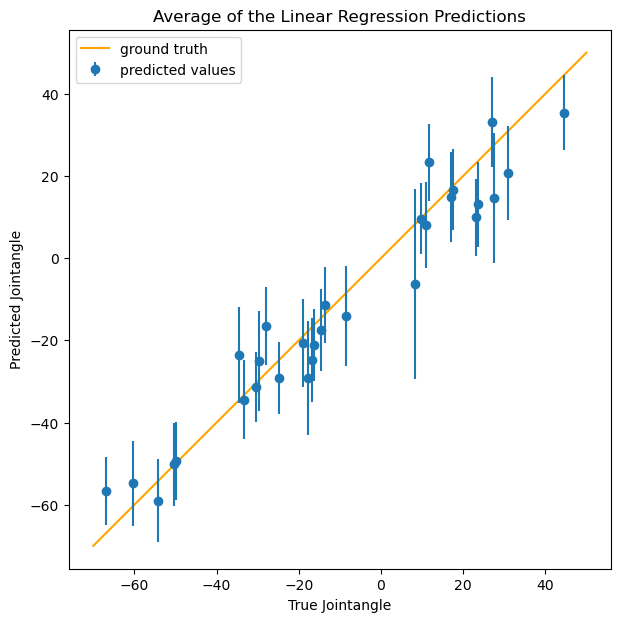

In [173]:
make_errorbar_plot(np.rad2deg(y_test), deg_preds)